In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
def fix_seeds(seed=42, deterministic=True):
    """
    Fix all random seeds for reproducibility.

    Args:
        seed (int): The seed value to use.
        deterministic (bool): If True, forces deterministic behavior in cuDNN (may reduce performance).
    """
    # Python's built-in random module
    random.seed(seed)

    # NumPy random generator
    np.random.seed(seed)

    # PyTorch seed for CPU & CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU

    # Ensuring deterministic behavior (if desired)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # Might slow down training but ensures reproducibility
fix_seeds()

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ResidualRaePINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, kr=20, kbc=10, kic=10):
        """
        Initialize the Residual-RAE PINN model.
        
        Args:
            input_dim: Dimension of input (typically 1 for 1D convection PDE - time and space)
            output_dim: Dimension of output (typically 1 for scalar solution u)
            hidden_dim: Number of neurons in each hidden layer
            num_layers: Number of hidden layers
            kr: Number of nearest neighbors for residual points
            kbc: Number of nearest neighbors for boundary condition points
            kic: Number of nearest neighbors for initial condition points
        """
        super(ResidualRaePINN, self).__init__()
        
        # Store parameters
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # k-nearest neighbors parameters
        self.kr = kr
        self.kbc = kbc
        self.kic = kic
        
        # Build the neural network
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        """Forward pass of the neural network"""
        return self.network(x)
    
    def compute_pde_residual(self, x, t, convection_velocity=1.0):
        """
        Compute the residual of the 1D convection PDE: du/dt + a * du/dx = 0
        
        Args:
            x: Spatial coordinates
            t: Time coordinates
            convection_velocity: Convection velocity parameter 'a'
            
        Returns:
            PDE residual at points (x,t)
        """
        # Create input tensor
        inputs = torch.cat([x, t], dim=1)
        inputs.requires_grad = True
        
        # Forward pass to get u(x,t)
        u = self(inputs)
        
        grad_u = torch.autograd.grad(
            u,
            inputs,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        u_x = grad_u[:, 0:1]  # derivative with respect to x
        u_t = grad_u[:, 1:2]
        
        # Compute PDE residual: du/dt + a * du/dx = 0
        residual = u_t + convection_velocity * u_x
        
        return residual
    
    def compute_ic_residual(self, x, t, u_ic):
        """
        Compute the residual of the initial condition: u(x,0) = u_ic(x)
        
        Args:
            x: Spatial coordinates at t=0
            t: Time coordinates (should be zeros)
            u_ic: Initial condition function
            
        Returns:
            Initial condition residual
        """
        inputs = torch.cat([x, t], dim=1)
        u_pred = self(inputs)
        u_actual = u_ic(x)
        residual = u_pred - u_actual
        return residual
    
    def compute_periodic_bc_residual(self, x_left, x_right, t_bc):
        """
        Compute the residual of the periodic boundary condition: u(x_min, t) = u(x_max, t)
        
        Args:
            x_left: Left boundary spatial coordinates
            x_right: Right boundary spatial coordinates
            t_bc: Time coordinates for boundary points
            
        Returns:
            Periodic boundary condition residual
        """
        # Create input tensors for left and right boundaries
        inputs_left = torch.cat([x_left, t_bc], dim=1)
        inputs_right = torch.cat([x_right, t_bc], dim=1)
        
        # Forward pass to get u at both boundaries
        u_left = self(inputs_left)
        u_right = self(inputs_right)
        
        # Compute residual: u(x_min, t) - u(x_max, t)
        residual = u_left - u_right
        
        return residual


In [5]:
class ResidualRaePINNSolver:
    def __init__(self, model, gamma_r=1.0, gamma_bc=1.0, gamma_ic=1.0, learning_rate=0.001, T=10):
        """
        Initialize the Residual-RAE PINN solver.
        
        Args:
            model: The PINN model
            gamma_r: Penalty coefficient for residual term
            gamma_bc: Penalty coefficient for boundary condition term
            gamma_ic: Penalty coefficient for initial condition term
            learning_rate: Learning rate for optimizer
            T: Period of dynamic sampling (number of epochs)
        """
        self.model = model
        self.gamma_r = gamma_r
        self.gamma_bc = gamma_bc
        self.gamma_ic = gamma_ic
        self.learning_rate = learning_rate
        self.T = T
        
        # Initialize optimizer
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        # Initialize point-wise weights
        self.lambda_r_near_p = None
        self.lambda_bc_near_p = None
        self.lambda_ic_near_p = None
        
    def initialize_weights(self, x_r, t_r, x_bc_left, x_bc_right, t_bc, x_ic, t_ic):
        """
        Initialize the point-wise weights.
        
        Args:
            x_r, t_r: PDE residual points
            x_bc_left, x_bc_right, t_bc: Boundary condition points
            x_ic, t_ic: Initial condition points
        """
        Nr = x_r.shape[0]
        Nbc = t_bc.shape[0]  # Number of time points at boundary
        Nic = x_ic.shape[0]
        
        # Initialize weights to 1.0
        self.lambda_r_near_p = torch.ones(Nr, requires_grad=False, device= device)
        self.lambda_r_near_p/= len(self.lambda_r_near_p)
        self.lambda_bc_near_p = torch.ones(Nbc, requires_grad=False, device=device)
        self.lambda_bc_near_p/= len(self.lambda_bc_near_p)
        self.lambda_ic_near_p = torch.ones(Nic, requires_grad=False, device= device)
        self.lambda_ic_near_p/= len(self.lambda_ic_near_p)
        
    def compute_weights(self, x_r, t_bc, x_ic,  R_r, R_bc, R_ic,indices_r, indices_bc, indices_ic, beta=0.9):
        """
        Compute the point-wise weights using k-nearest neighbors and residuals.
        
        Args:
            x_r, t_r: PDE residual points
            x_bc_left, x_bc_right, t_bc: Boundary condition points
            x_ic, t_ic: Initial condition points
            R_r, R_bc, R_ic: Residuals at each point
            beta: Weight for previous lambda values (momentum)
            
        Returns:
            Updated weights
        """
        # Compute the RAE weights for residual points
        R_r_abs = torch.abs(R_r).detach()
        total_R = R_r_abs.sum() + 1e-10
        w_p = R_r_abs / total_R
        new_lambda_r = torch.zeros_like(self.lambda_r_near_p)
        
        for i in range(x_r.shape[0]):
            neighbors_idx = indices_r[i]
            new_lambda_r[i] = w_p[neighbors_idx].sum()/self.model.kr
            
        R_bc_abs = torch.abs(R_bc).detach()
        new_lambda_bc = torch.zeros_like(self.lambda_bc_near_p)
        total_R = R_bc_abs.sum()+1e-10
        w_p = R_bc_abs/total_R
        
        for i in range(t_bc.shape[0]):
            neighbors_idx = indices_bc[i]
            new_lambda_bc[i] = w_p[neighbors_idx].sum() / self.model.kbc

        R_ic_abs = torch.abs(R_ic).detach()
        new_lambda_ic = torch.zeros_like(self.lambda_ic_near_p)
        total_R = R_ic_abs.sum() + 1e-10
        w_p = R_ic_abs / total_R

        for i in range(x_ic.shape[0]):
            neighbors_idx = indices_ic[i]
            new_lambda_ic[i] = w_p[neighbors_idx].sum()/self.model.kic
        
        # Update weights with momentum
        self.lambda_r_near_p = beta * new_lambda_r + (1 - beta) * self.lambda_r_near_p
        self.lambda_bc_near_p = beta * new_lambda_bc + (1 - beta) * self.lambda_bc_near_p
        self.lambda_ic_near_p = beta * new_lambda_ic + (1 - beta) * self.lambda_ic_near_p
        return self.lambda_r_near_p, self.lambda_bc_near_p, self.lambda_ic_near_p
    
    def train(self, x_r, t_r, x_bc_left, x_bc_right, t_bc, x_ic, t_ic, u_ic_fn, epochs=10000, conv_velocity=1.0, verbose=True):
        """
        Train the RAE-PINN model with periodic boundary conditions.
        
        Args:
            x_r, t_r: PDE residual points
            x_bc_left: Left boundary spatial coordinates
            x_bc_right: Right boundary spatial coordinates
            t_bc: Time coordinates for boundary points
            x_ic, t_ic: Initial condition points
            u_ic_fn: Initial condition function
            epochs: Number of training epochs
            conv_velocity: Convection velocity for the PDE
            verbose: Whether to print training progress
            
        Returns:
            Model and final loss
        """
        # Initialize weights
        self.initialize_weights(x_r, t_r, x_bc_left, x_bc_right, t_bc, x_ic, t_ic)
        
        X_r = torch.cat([x_r, t_r], dim=1).detach().cpu().numpy()
        nn_r = NearestNeighbors(n_neighbors=self.model.kr+1, algorithm='auto').fit(X_r)
        _, indices_r = nn_r.kneighbors(X_r)
        indices_r = indices_r[:, 1:]

        X_bc = t_bc.detach().cpu().numpy()
        nn_bc = NearestNeighbors(n_neighbors=min(self.model.kbc+1, X_bc.shape[0]), algorithm='auto').fit(X_bc)
        _, indices_bc = nn_bc.kneighbors(X_bc)
        indices_bc = indices_bc[:, 1:] if indices_bc.shape[1] > 1 else indices_bc
        
        X_ic = torch.cat([x_ic, t_ic], dim=1).detach().cpu().numpy()
        nn_ic = NearestNeighbors(n_neighbors=min(self.model.kic+1, X_ic.shape[0]), algorithm='auto').fit(X_ic)
        _, indices_ic = nn_ic.kneighbors(X_ic)
        indices_ic = indices_ic[:, 1:] if indices_ic.shape[1] > 1 else indices_ic

        # Training loop
        for epoch in tqdm(range(epochs)):
            # Forward pass to compute residuals
            R_r = self.model.compute_pde_residual(x_r, t_r, conv_velocity)
            R_bc = self.model.compute_periodic_bc_residual(x_bc_left, x_bc_right, t_bc)
            R_ic = self.model.compute_ic_residual(x_ic, t_ic, u_ic_fn)
            
            # Update weights every T epochs
            if epoch % self.T == 0:
                self.compute_weights(x_r,t_bc,x_ic,R_r,R_bc,R_ic,indices_r,indices_bc, indices_ic)
            
            # Compute weighted loss
            loss_r = (self.lambda_r_near_p * (R_r**2)).sum()
            loss_bc = (self.lambda_bc_near_p * (R_bc**2)).sum()
            loss_ic = (self.lambda_ic_near_p * (R_ic**2)).sum()
            
            # Total loss with penalty coefficients
            loss = self.gamma_r * loss_r + self.gamma_bc * loss_bc + self.gamma_ic * loss_ic
            
            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Print progress
            if verbose and epoch % (epochs // 10 if epochs // 10 > 0 else 1) == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}, "
                      f"PDE Loss = {loss_r.item():.6f}, "
                      f"BC Loss = {loss_bc.item():.6f}, "
                      f"IC Loss = {loss_ic.item():.6f}")

        return self.model, loss.item()

In [ ]:
# Define PDE domain
x_min, x_max = 0.0, 2*np.pi
t_min, t_max = 0.0, 1.0

# Generate training points
n_x, n_t = 50, 50
n_ic = 512
n_bc = 256

x_r = torch.linspace(x_min, x_max, n_x).repeat(n_t, 1).t().reshape(-1, 1).to(device)
t_r = torch.linspace(t_min, t_max, n_t).repeat(n_x).reshape(-1, 1).to(device)

x_ic = torch.linspace(x_min, x_max, n_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros(n_ic, 1).to(device)

x_bc_left = torch.full((n_bc, 1), x_min).to(device)
x_bc_right = torch.full((n_bc, 1), x_max).to(device)
t_bc = torch.linspace(t_min, t_max, n_bc).reshape(-1, 1).to(device)

def u_ic_fn(x):
    return torch.sin(x)

# Create model and solver
input_dim = 2  # (x, t)
output_dim = 1  # u(x,t)
hidden_dim = 50
num_layers = 4

# Hyperparameters from the algorithm
kr = 20      # k nearest neighbors for residual points
kbc = 10     # k nearest neighbors for boundary points
kic = 10     # k nearest neighbors for initial condition points
gamma_r = 1.0   # penalty coefficient for residual
gamma_bc = 10.0  # penalty coefficient for boundary
gamma_ic = 10.0  # penalty coefficient for initial condition
learning_rate = 1e-3
T = 1

# Initialize model and solver
model = ResidualRaePINN(input_dim, output_dim, hidden_dim, num_layers, kr, kbc, kic).to(device)
solver = ResidualRaePINNSolver(model, gamma_r, gamma_bc, gamma_ic, learning_rate, T)

In [22]:
model,final_loss = solver.train(
    x_r, t_r, 
    x_bc_left, x_bc_right, t_bc, 
    x_ic, t_ic, 
    u_ic_fn, 
    epochs=100000,
    conv_velocity=70.0
)

print(f"Training complete. Final loss: {final_loss:.6f}")

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 2/100000 [00:00<4:28:27,  6.21it/s]

Epoch 0: Loss = 5.057431, PDE Loss = 0.090515, BC Loss = 0.492126, IC Loss = 0.004565


 10%|█         | 10002/100000 [23:16<3:24:31,  7.33it/s]

Epoch 10000: Loss = 4.717248, PDE Loss = 0.075779, BC Loss = 0.459800, IC Loss = 0.004347


 20%|██        | 20002/100000 [46:33<3:21:13,  6.63it/s]

Epoch 20000: Loss = 4.386370, PDE Loss = 0.057310, BC Loss = 0.428440, IC Loss = 0.004466


 30%|███       | 30002/100000 [1:09:53<2:38:19,  7.37it/s]

Epoch 30000: Loss = 4.769471, PDE Loss = 0.148503, BC Loss = 0.447792, IC Loss = 0.014305


 40%|████      | 40002/100000 [1:33:52<2:25:13,  6.89it/s]

Epoch 40000: Loss = 4.147765, PDE Loss = 0.047444, BC Loss = 0.406198, IC Loss = 0.003834


 50%|█████     | 50002/100000 [1:58:24<2:10:38,  6.38it/s]

Epoch 50000: Loss = 3.888168, PDE Loss = 0.041327, BC Loss = 0.380760, IC Loss = 0.003924


 60%|██████    | 60002/100000 [2:23:02<1:31:18,  7.30it/s]

Epoch 60000: Loss = 52.420238, PDE Loss = 38.781086, BC Loss = 1.071257, IC Loss = 0.292658


 70%|███████   | 70002/100000 [2:46:32<1:08:44,  7.27it/s]

Epoch 70000: Loss = 5.255433, PDE Loss = 1.588876, BC Loss = 0.362685, IC Loss = 0.003970


 80%|████████  | 80002/100000 [3:09:38<46:18,  7.20it/s]  

Epoch 80000: Loss = 3.239784, PDE Loss = 0.062919, BC Loss = 0.312901, IC Loss = 0.004785


 90%|█████████ | 90002/100000 [3:33:08<23:06,  7.21it/s]

Epoch 90000: Loss = 2.807184, PDE Loss = 0.031809, BC Loss = 0.274855, IC Loss = 0.002682


100%|██████████| 100000/100000 [3:57:01<00:00,  7.03it/s]

Training complete. Final loss: 3.112111


In [23]:
def exact_solution_fft(x_array, t, h_values, beta, x_max):
    """
    Computes the exact solution of the 1D convection PDE using the Fourier transform approach.
    Assumes periodic boundary conditions on [0, x_max).

    Args:
        x_array (np.ndarray): 1D array of x-values (length N) on [0, x_max), evenly spaced.
        t (float): Time at which to evaluate the solution.
        h_values (np.ndarray): 1D array of h(x_array), same length as x_array.
        beta (float): Convection speed.
        x_max (float): Domain length for periodic boundary conditions.

    Returns:
        np.ndarray: Real part of the exact solution u(x, t) on the same grid x_array.
    """
    N = len(x_array)
    # Forward FFT of initial condition
    H_k = np.fft.fft(h_values)
    # Wavenumbers k: 2π * (integer) / x_max
    k_array = 2 * np.pi * np.fft.fftfreq(N, d=(x_max / N))
    # Multiply by e^{- i * beta * k * t}
    phase_factor = np.exp(-1j * beta * k_array * t)
    U_k = H_k * phase_factor
    # Inverse FFT to get solution
    u_vals = np.fft.ifft(U_k)
    return u_vals.real

In [24]:
model.eval()

ResidualRaePINN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [25]:
Nx = 256
Nt = 100
x_vals = np.linspace(0, x_max, Nx, endpoint=False)
t_vals = np.linspace(0, t_max, Nt)
X, T = np.meshgrid(x_vals, t_vals)

In [26]:
h_values = np.sin(x_vals)
U_exact = np.zeros_like(X)
for i, t_val in enumerate(t_vals):
    U_exact[i, :] = exact_solution_fft(x_vals, t_val, h_values, 70.0, x_max)

In [27]:
XT = np.stack([X.ravel(), T.ravel()], axis=1)
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)
with torch.no_grad():
    U_pred_tensor = model(XT_tensor)
U_pred = U_pred_tensor.cpu().numpy().reshape(Nt, Nx)

In [28]:
U_diff = U_pred - U_exact

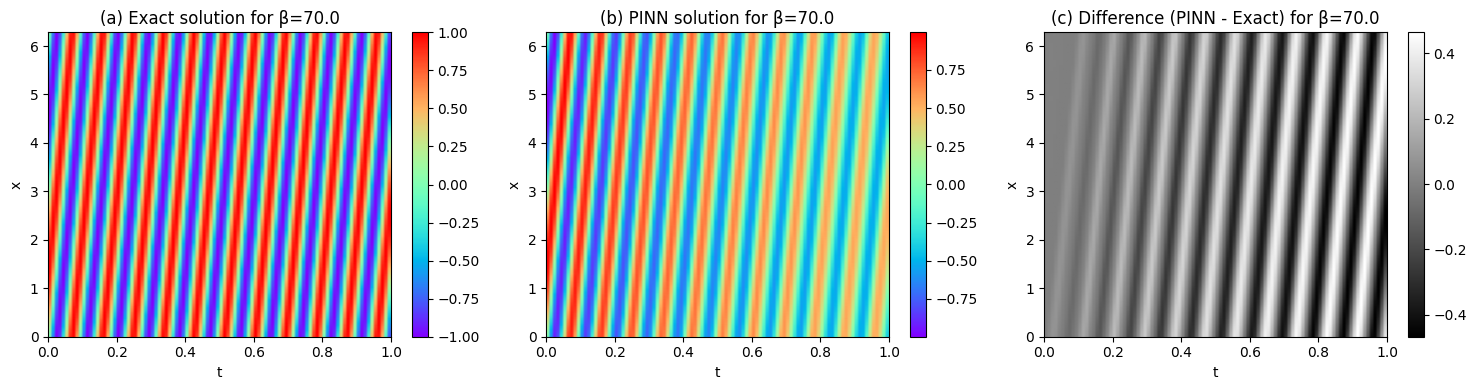

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (a) Exact solution
c1 = axes[0].imshow(
  U_exact.T,
  extent=[0, t_max, 0, x_max],  # x horizontal, t vertical
  origin="lower",
  aspect="auto",
  cmap="rainbow"
)
axes[0].set_title(f"(a) Exact solution for β={70.0}")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x")
fig.colorbar(c1, ax=axes[0])

# (b) PINN solution
c2 = axes[1].imshow(
    U_pred.T,
    extent=[0, t_max, 0, x_max],
    origin="lower",
    aspect='auto',
    cmap='rainbow'
)
axes[1].set_title(f"(b) PINN solution for β={70.0}")
axes[1].set_xlabel("t")
axes[1].set_ylabel("x")
fig.colorbar(c2, ax=axes[1])

# (c) Difference
c3 = axes[2].imshow(
    U_diff.T,
    extent=[0, t_max, 0, x_max],
    origin="lower",
    aspect='auto',
    cmap='gray'
)
axes[2].set_title(f"(c) Difference (PINN - Exact) for β={70.0}")
axes[2].set_xlabel("t")
axes[2].set_ylabel("x")
fig.colorbar(c3, ax=axes[2])

plt.tight_layout()
plt.show()


In [30]:
torch.save(model,"rae-pinn.pth")